<a href="https://colab.research.google.com/github/suwisitlk/229352-StatisticalLearning/blob/main/Lab11_Fine_Tuning_Reasoning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

# Fine-Tuning Qwen3 for Thai Text Reasoning

Today, you will learn how to take a pre-trained Large Language Model (LLM) and specialize it for **Thai text reasoning** using the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT).

We will be using [**Unsloth**](https://docs.unsloth.ai/get-started/all-our-models) to speeds up finetuning and reduces memory usage, making it possible to train in Google Colab.

If GPUs are not available in your Colab, you might want to try these two alternatives:
1. [Kaggle](https://www.kaggle.com)
2. [lightning.ai](https://lightning.ai)

### Installation

In [1]:
%%capture
import os
!pip install --upgrade -qqq uv
try: import numpy, PIL; _numpy = f'numpy=={numpy.__version__}'; _pil = f'pillow=={PIL.__version__}'
except: _numpy = "numpy"; _pil = "pillow"
try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
except: is_t4 = False
_vllm, _triton = ('vllm==0.9.2', 'triton==3.2.0') if is_t4 else ('vllm==0.15.1', 'triton')
!uv pip install -qqq --upgrade {_vllm} {_numpy} {_pil} torchvision bitsandbytes xformers unsloth
!uv pip install -qqq {_triton}
!uv pip install transformers==4.56.2
!uv pip install --no-deps trl==0.22.2

### Fine-tuning Qwen3 with Unsloth

#### Transformer in Qwen3 vs GPT-2
<img src="https://substackcdn.com/image/fetch/$s_!GGk9!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa8fa602a-aa4d-4526-9252-c2f09dd5de92_1871x1920.png" alt="transformers" width="600"/>

[Source: [Sebastian Raschka](https://magazine.sebastianraschka.com/p/qwen3-from-scratch)]

In [3]:
!pip install --upgrade wandb unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 7.34.0
    Uninstalling protobuf-7.34.0:
      Successfully uninstalled protobuf-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.5 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.5 which is incompatible.
grpcio-st

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = False,
    max_lora_rank = lora_rank,
)

#### Low-Rank Adaptation (LoRA)
<img src="https://substackcdn.com/image/fetch/$s_!LXL5!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F7ab94b67-4efa-45e2-9a77-3121d6c88c45_1284x364.png" alt="LoRA" width="600"/>

[Source: [Dasha Herrmannova](https://oneminutenlp.com/p/low-rank-adaptation)]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)

Unsloth 2026.2.1 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


<a name="Data"></a>
### Data Prep
Use the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT) provided by [iApp Technology](https://iapp.co.th/).

In [ ]:
from datasets import load_dataset
reasoning_dataset = load_dataset("iapp/Thai-R1-Distill-SFT", split = "train")

Let's see the structure of both datasets:

In [5]:
reasoning_dataset

Dataset({
    features: ['reannotated_assistant_content', 'problem', 'solution', 'id', 'source', 'verified', 'quality_metrics'],
    num_rows: 10000
})

We now convert the reasoning dataset into conversational format:

In [ ]:
from datasets import Dataset

def generate_conversation(examples):
    problems  = examples["problem"]
    solutions = examples["reannotated_assistant_content"]
    conversations = []
    for problem, solution in zip(problems, solutions):
        conversations.append([
            {"role" : "user",      "content" : problem},
            {"role" : "assistant", "content" : solution},
        ])
    return { "conversations": conversations, }

prepared_dataset = reasoning_dataset.to_pandas()
prepared_dataset["text"] = tokenizer.apply_chat_template(
    list(reasoning_dataset.map(generate_conversation, batched = True)["conversations"]),
    tokenize = False,
)
prepared_dataset = Dataset.from_pandas(prepared_dataset)

Let's see the first transformed row:

In [6]:
print(prepared_dataset[0]['text'])

<|im_start|>user
มีเด็กชาย 27 คนและเด็กหญิง 35 คนอยู่ในสนามเด็กเล่นในช่วงพัก มีเด็ก _____ คนอยู่ในสนามเด็กเล่นในช่วงพัก<|im_end|>
<|im_start|>assistant
<think>
ก่อนอื่น ฉันต้องคำนวณจำนวนเด็กทั้งหมดในสนามเด็กเล่นโดยนำจำนวนเด็กชายและเด็กหญิงมาบวกกัน มีเด็กชาย 27 คนและเด็กหญิง 35 คน เมื่อบวกกันแล้ว เด็กชาย 27 คน + เด็กหญิง 35 คน = เด็ก 62 คน ดังนั้น จำนวนเด็กทั้งหมดในสนามเด็กเล่นคือ 62 คน
</think>

 ในการหาจำนวนเด็กทั้งหมดในสนามเด็กเล่น เราเพียงแค่บวกจำนวนเด็กชายและเด็กหญิงเข้าด้วยกัน \[ \text{จำนวนเด็กทั้งหมด} = \text{จำนวนเด็กชาย} + \text{จำนวนเด็กหญิง} \] แทนค่าที่กำหนด: \[ \text{จำนวนเด็กทั้งหมด} = 27 \text{ เด็กชาย} + 35 \text{ เด็กหญิง} = 62 \text{ เด็ก} \] **คำตอบสุดท้าย:** \[ \boxed{62} \]<|im_end|>



<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

First, let's clear some memory.

In [7]:
import gc

try:
  del reasoning_dataset
except NameError:
  pass

# Force Python to clean up the deleted objects from CPU RAM
gc.collect()

# Empty the PyTorch CUDA cache
torch.cuda.empty_cache()

In [ ]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = prepared_dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",
    ),
)

Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [ ]:
trainer_stats = trainer.train()

<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [10]:
FastLanguageModel.for_inference(model)

messages = [
    {"role" : "user", "content" : "จงหาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 - y^2 = 5"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Enable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1500, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
โอเค ฉันมีปัญหาที่ว่า "หาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 - y^2 = 5" ฉันพยายามคิดว่าจะทำอย่างไร ฉันรู้ว่า x^2 - y^2 สามารถแยกตัวประกอบได้เป็น (x - y)(x + y) ดังนั้นปัญหาจึงกลายเป็น (x - y)(x + y) = 5 ตอนนี้ ฉันจำได้ว่า 5 เป็นจำนวนเฉพาะ ซึ่งหมายความว่ามีตัวประกอบเพียงสองตัว: 1 และ 5 หรือ -1 และ -5 ดังนั้น ฉันจึงต้องพิจารณาว่า (x - y) และ (x + y) สามารถเป็นตัวประกอบเหล่านั้นได้อย่างไร ตัวแรกที่ฉันคิดถึงคือ x - y = 1 และ x + y = 5 ถ้าฉันแก้ระบบสมการเหล่านี้ ฉันจะได้ x - y = 1 x + y = 5 หากฉันบวกสมการทั้งสองเข้าด้วยกัน ฉันจะได้ 2x = 6 ดังนั้น x = 3 จากนั้นแทน x = 3 ลงในสมการแรก: 3 - y = 1 ดังนั้น y = 2 ดังนั้น (3, 2) จึงเป็นคำตอบหนึ่ง แต่ฉันยังต้องพิจารณาตัวประกอบอื่นๆ ด้วย ตัวต่อไปคือ x - y = -1 และ x + y = -5 ฉันจะแก้ระบบสมการนี้: x - y = -1 x + y = -5 หากฉันบวกสมการทั้งสองเข้าด้วยกัน ฉันจะได้ 2x = -6 ดังนั้น x = -3 จากนั้นแทน x = -3 ลงในสมการแรก: -3 - y = -1 ดังนั้น y = -2 ดังนั้น (-3, -2) จึงเป็นคำตอบอีกตัว ตอนนี้ ฉันต้องตรวจสอบว่ามีตัวประกอบอื่นๆ หรือไม่ ตัวอย่างเช่น x - y = 5

### Exercise 1: Ask the model a challenging **math problem in Thai**. You may increase the value of `max_new_tokens` if the model's answer is too short. Does the model solve your problem correctly?

In [11]:
### YOUR CODE HERE ###

messages = [
    {"role" : "user", "content" : "ไก่2ตัวมี4ขาแล้วไก่2ขามีกี่ตัว"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Enable thinking
)

_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 3000, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For non thinking #Model Recomented
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
ขั้นแรก ฉันต้องเข้าใจปัญหา ปัญหาบอกว่าไก่ 2 ตัวมี 4 ขา ตอนนี้คำถามคือ หากมี 4 ขา ไก่จะมีกี่ตัว ฉันจะใช้การวิเคราะห์ขั้นตอนต่อขั้นตอนเพื่อหาคำตอบ ปัญหาบอกว่าไก่ 2 ตัวมี 4 ขา ดังนั้น ฉันจึงกำหนดว่า 2 ตัว = 4 ขา จากนั้น ฉันจะต้องหาว่า 4 ขาจะมีไก่กี่ตัว ฉันจะใช้การหารเพื่อหาคำตอบ ฉันจะหารจำนวนขาโดยจำนวนไก่ต่อตัว 4 ขา ÷ 2 ตัว = 2 ตัว ดังนั้น 4 ขาจะมีไก่ 2 ตัว ฉันจะตรวจสอบคำตอบอีกครั้งเพื่อให้แน่ใจว่าถูกต้อง ถ้าไก่ 2 ตัวมี 4 ขา ไก่ 4 ขาจะมีไก่ 2 ตัว ซึ่งตรงกับคำตอบที่ฉันได้ ดังนั้นคำตอบของฉันจึงถูกต้อง ฉันจะเขียนคำตอบสุดท้ายของฉันในกล่อง
</think>

 ปัญหา: ไก่ 2 ตัวมี 4 ขา ไก่ 4 ขาจะมีไก่กี่ตัว วิธีแก้ปัญหา: 1. **กำหนดอัตราส่วน:** - ไก่ 2 ตัวมี 4 ขา - ดังนั้น จำนวนไก่ต่อขาคือ \(\frac{2 \text{ ตัว}}{4 \text{ ขา}} = \frac{1 \text{ ตัว}}{2 \text{ ขา}}\) 2. **คำนวณจำนวนไก่สำหรับ 4 ขา:** - ใช้อัตราส่วน \(\frac{1 \text{ ตัว}}{2 \text{ ขา}}\) - สำหรับ 4 ขา: \(\frac{1 \text{ ตัว}}{2 \text{ ขา}} \times 4 \text{ ขา} = 2 \text{ ตัว}\) คำตอบสุดท้าย: \(\boxed{2}\)<|im_end|>


**Answer to Exercise 1**

- จากโจทย์ถามว่า ไก่ 2 ตัว มี 4 ขา แล้วไก่ 2 ขามีกี่ตัว ซึ่งโมเดลทำการคำนวณได้ถูกต้อง ซึ่งคำตอบที่ถูกคือ 1 ตัวนั่นเองงงงงง! (แต่จริงๆ คือทุกตัว @-@)
- Note : เพิ่ม token แล้วอธิบายดีขึ้น

### Visualizing Attention

In [12]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np

# Add the font to Matplotlib's registry
fm.fontManager.addfont('thsarabunnew-webfont.ttf')

# Set it as the default font for all plots
mpl.rc('font', family='TH Sarabun New', size=14)

### Exercise 2: Fill in the ##TODO## part in the `visualize_attention()` function below to calculate the product between the query matrix `Q` and the key matrix `K`.

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def rotate_half(x):
    """Rotates half the hidden dimensions of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# Define a global dictionary to store the attention matrix
attention_viz_data = {}

def visualize_attention(model, tokenizer, prompt, layer_number):
    """
    Visualizes the QK^T attention matrix for a given prompt and layer,

    Args:
        model: The Unsloth Qwen3 14B model.
        tokenizer: The tokenizer for the model.
        prompt (str): The input text prompt.
        layer_number (int): The decoder layer number to visualize.
    """
    attention_viz_data.clear()

    attention_layer = model.base_model.model.model.layers[layer_number].self_attn
    original_forward = attention_layer.forward

    def new_forward(self, hidden_states, *args, **kwargs):
        """A new forward method to capture the QK^T matrix."""

        bsz, q_len, _ = hidden_states.size()

        # Project to Q, K
        Q_all_heads = self.q_proj(hidden_states)
        K_all_heads = self.k_proj(hidden_states)

        # Reshape for multi-head attention. Note the different head counts.
        Q_all_heads = Q_all_heads.view(bsz, q_len, self.config.num_attention_heads, self.head_dim).transpose(1, 2)
        K_all_heads = K_all_heads.view(bsz, q_len, self.config.num_key_value_heads, self.head_dim).transpose(1, 2)

        # Get rotary embeddings
        cos, sin = self.rotary_emb(K_all_heads, seq_len=q_len)

        # Apply rotary embeddings directly
        Q_all_heads = (Q_all_heads * cos) + (rotate_half(Q_all_heads) * sin)
        K_all_heads = (K_all_heads * cos) + (rotate_half(K_all_heads) * sin)

        # Repeat the key heads to match the number of query heads.
        num_key_value_groups = self.config.num_attention_heads // self.config.num_key_value_heads
        if num_key_value_groups > 1:
            K_all_heads = K_all_heads.repeat_interleave(num_key_value_groups, dim=1)

        # Now, the dimensions match for matrix multiplication:
        # Q_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]
        # K_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]

        Q = Q_all_heads[0, 0]  # Queries of the first head
        K = K_all_heads[0, 0]  # Keys of the first head

        ####### TODO: CALCULATE Softmax(QK^T / √head_dim)          #######
        ####### When computing Softmax, normalize along each row.  #######
        # 1. ทำ Dot product ระหว่าง Q และ K Transpose
        scores = (Q @ K.t()) / np.sqrt(self.head_dim)
        # 2. ผ่านฟังก์ชัน Softmax ตามแนวนอน (dim=-1) เพื่อให้ผลรวมแต่ละแถว (Query) มีค่า = 1.0
        attention = torch.nn.functional.softmax(scores, dim=-1)


        ##################################################################

        # Store the matrix for visualization
        attention_viz_data['qk_t'] = attention.detach()

        # Call the original forward method
        return original_forward(hidden_states, *args, **kwargs)

    try:
        attention_layer.forward = new_forward.__get__(attention_layer, type(attention_layer))

        inputs = tokenizer(prompt, return_tensors="pt")
        input_ids = inputs.input_ids.to(model.device)

        with torch.no_grad():
            _ = model(input_ids)

    finally:
        attention_layer.forward = original_forward

    # Visualize the captured data
    if 'qk_t' in attention_viz_data:
        qk_matrix = attention_viz_data['qk_t'].cpu().float().numpy()

        tokens = []
        for tok_id in input_ids[0]:
            decoded = tokenizer.decode([tok_id])

            if not decoded.strip():
                decoded = tokenizer.convert_ids_to_tokens([tok_id])[0]

            decoded = decoded.replace('Ġ', ' ')
            tokens.append(decoded)

        plt.figure(figsize=(12, 10))
        im = plt.imshow(qk_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(im, label='Attention Score (Logits)')
        plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
        plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
        plt.xlabel("Key Tokens")
        plt.ylabel("Query Tokens")
        plt.title(f"QK^T Matrix Visualization for Layer {layer_number}, Head 0")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Failed to capture the QK^T matrix for layer {layer_number}.")

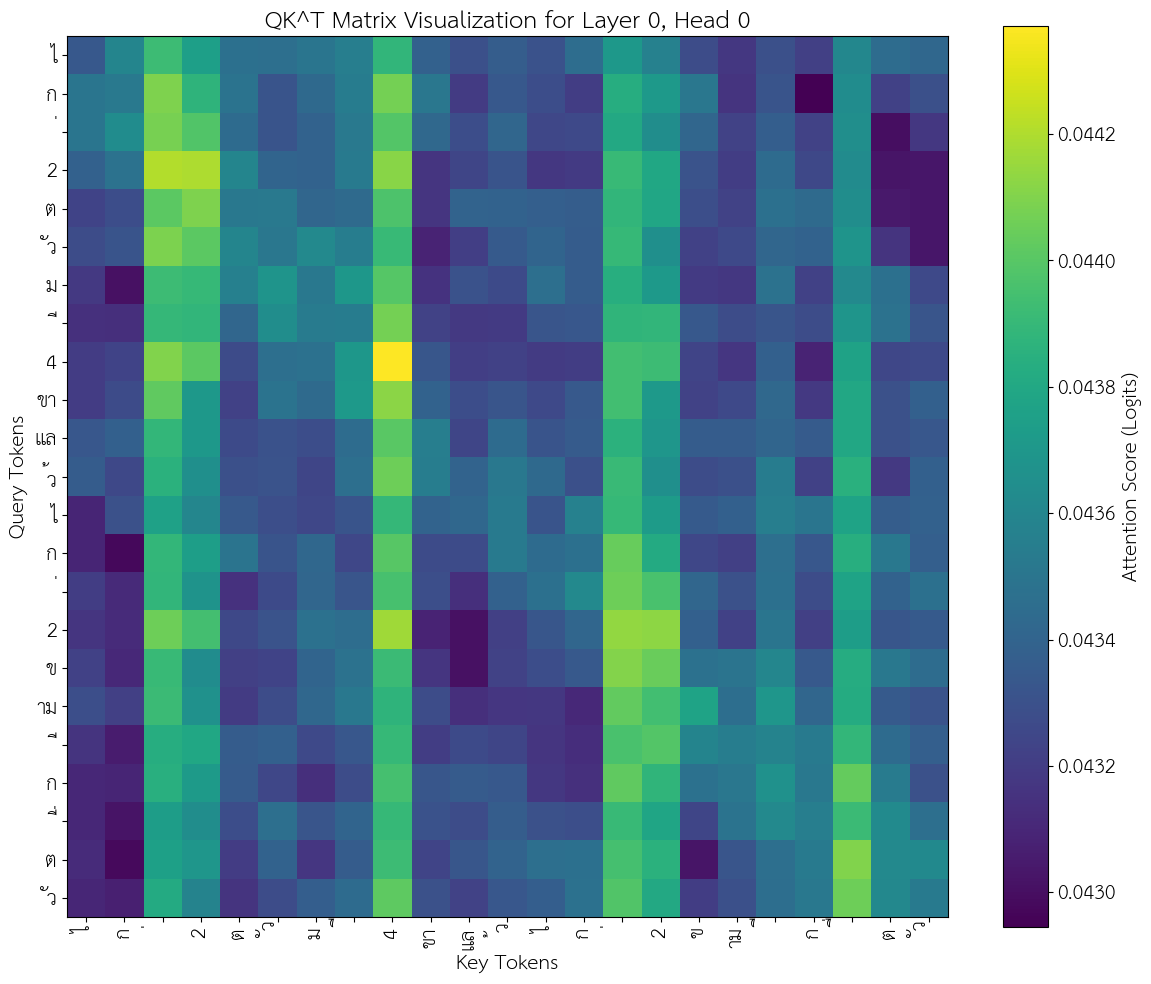

In [14]:
example_text = "ไก่2ตัวมี4ขาแล้วไก่2ขามีกี่ตัว"

visualize_attention(model, tokenizer, example_text, 0)

### Exercise 3: Choose your own example of **math problem in Thai**. Find **two** pairs of two distinct words with the highest attention values. Why do you think those two pairs have the highest attention values?

**Answers to Exercise 3**

2. Two pairs with the highest attention values:

*   Pair 1: โทเค็น "2" และ "  ่ "(ไม้เอก)
    *   โทเค็น " ่ " คือส่วนท้ายของคำว่า "ไก่" การที่ตัวเลข "2" มี Attention ชี้ไปหาโทเค็นนี้ แสดงว่าโมเดลกำลังจับคู่คำขยายเพื่อทำความเข้าใจว่า เลข 2 คือจำนวนของสิ่งใด (ไก่)
*   Pair 2: โทเค็น "2" และ "4"
    * เป็นการเชื่อมโยงข้อมูลเชิงปริมาณโมเดลกำลังจับความสัมพันธ์ระหว่างตัวเลขที่เป็นเงื่อนไขสำคัญในโจทย์ เพื่อเตรียมนำไปวิเคราะห์และคำนวณหาคำตอบในเลเยอร์ถัดๆ ไป

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

### Saving to float16 for VLLM

Unsloth also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False: # Pushing to HF Hub
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")
